In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df=pd.read_csv('tmnist.csv')

In [3]:
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Step 2: Map all unique character labels to numeric indices
classes = sorted(df['labels'].unique())  # ['!', '"', ..., 'z']
char_to_index = {char: i for i, char in enumerate(classes)}
index_to_char = {i: char for char, i in char_to_index.items()}

# Step 3: Convert labels to numbers
df['label_index'] = df['labels'].map(char_to_index)

# Step 4: Extract features and labels
labels = df['label_index'].values.astype(int)
pixels = df.iloc[:, 2:786].values.astype(np.float32)  # skip 'names' and 'labels'

# Step 5: Stack, shuffle, split
data = np.column_stack((labels, pixels))
np.random.shuffle(data)

# Step 6: Split and normalize
m, n = data.shape
data_dev = data[:1000].T
Y_dev = data_dev[0].astype(int)
X_dev = data_dev[1:] / 255.0

data_train = data[1000:].T
Y_train = data_train[0].astype(int)
X_train = data_train[1:] / 255.0

_, m_train = X_train.shape



In [5]:
X_train[:,0].shape

(784,)

In [6]:
Y_train

array([80, 57, 71, ..., 62, 89, 53])

In [7]:
def init_params():
    W1 = np.random.randn(256, 784) * np.sqrt(2. / 784)
    b1 = np.zeros((256, 1))
    W2 = np.random.randn(512, 256) * np.sqrt(2. / 256)
    b2 = np.zeros((512, 1))
    W3 = np.random.randn(94, 512) * np.sqrt(2. / 512)
    b3 = np.zeros((94, 1))
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Stability fix
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3


def ReLU_derive(Z):
    return Z > 0


def one_hot(Y):
    one_hot_Y = np.zeros((94, Y.size))  # 94 classes
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    m = X.shape[1]
    one_hot_Y = one_hot(Y)

    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m) * dZ3.dot(A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    dZ2 = W3.T.dot(dZ3) * ReLU_derive(Z2)
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * ReLU_derive(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    return W1, b1, W2, b2, W3, b3


In [8]:
def get_predictions(A2):
    return np.argmax(A2, axis=0)  # Each column = one sample

def get_accuracy(predictions, Y):
    accuracy = np.sum(predictions == Y) / Y.size
    return accuracy

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3,
                                               dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 10 == 0 or i == iterations - 1:
            predictions = get_predictions(A3)
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i} - Accuracy: {acc * 100:.2f}%")

    return W1, b1, W2, b2, W3, b3


In [ ]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 0.1, 1000)

Iteration 0 - Accuracy: 1.79%
Iteration 10 - Accuracy: 6.65%
Iteration 20 - Accuracy: 17.44%
Iteration 30 - Accuracy: 30.81%
Iteration 40 - Accuracy: 42.81%
Iteration 50 - Accuracy: 51.80%
Iteration 60 - Accuracy: 58.56%
Iteration 70 - Accuracy: 63.40%
Iteration 80 - Accuracy: 66.88%
Iteration 90 - Accuracy: 69.28%
Iteration 100 - Accuracy: 71.07%
Iteration 110 - Accuracy: 72.30%
Iteration 120 - Accuracy: 73.18%
Iteration 130 - Accuracy: 73.43%
Iteration 140 - Accuracy: 74.00%
Iteration 150 - Accuracy: 74.47%
Iteration 160 - Accuracy: 74.82%
Iteration 170 - Accuracy: 75.04%
Iteration 180 - Accuracy: 75.32%
Iteration 190 - Accuracy: 75.67%
Iteration 200 - Accuracy: 76.02%
Iteration 210 - Accuracy: 76.35%
Iteration 220 - Accuracy: 76.65%
Iteration 230 - Accuracy: 76.86%
Iteration 240 - Accuracy: 77.03%
Iteration 250 - Accuracy: 77.31%
Iteration 260 - Accuracy: 77.60%
Iteration 270 - Accuracy: 77.89%
Iteration 280 - Accuracy: 78.15%
Iteration 290 - Accuracy: 78.42%
Iteration 300 - Accurac

In [11]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions


def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3)
    label = Y_train[index]

    pred_letter = index_to_char[prediction[0]]
    label_letter = index_to_char[int(label)]

    print("Prediction:", pred_letter, f"(class {prediction[0]})")
    print("Label     :", label_letter, f"(class {int(label)})")

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f"Predicted: {pred_letter}, Actual: {label_letter}")
    plt.axis('off')
    plt.show()




🧪 Testing sample #0
Prediction: q (class 80)
Label     : q (class 80)


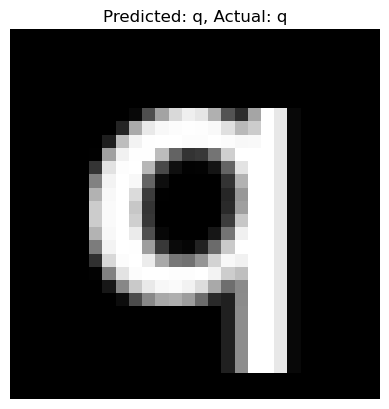


🧪 Testing sample #1
Prediction: z (class 89)
Label     : Z (class 57)


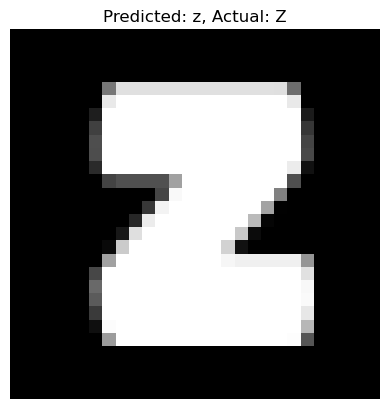


🧪 Testing sample #2
Prediction: h (class 71)
Label     : h (class 71)


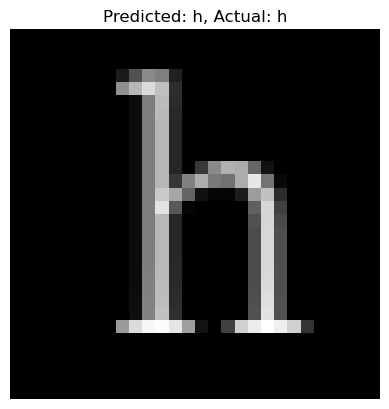


🧪 Testing sample #3
Prediction: < (class 27)
Label     : < (class 27)


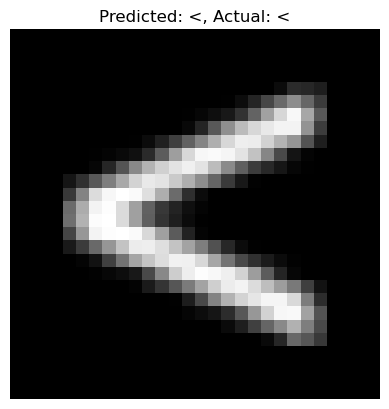


🧪 Testing sample #4
Prediction: & (class 5)
Label     : 8 (class 23)


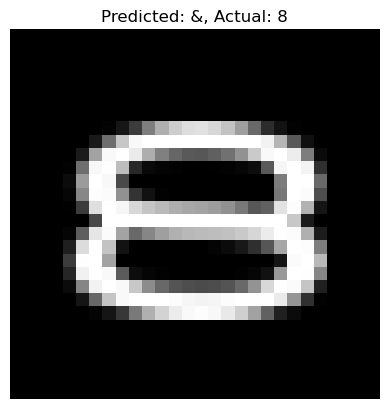


🧪 Testing sample #5
Prediction: ! (class 0)
Label     : ! (class 0)


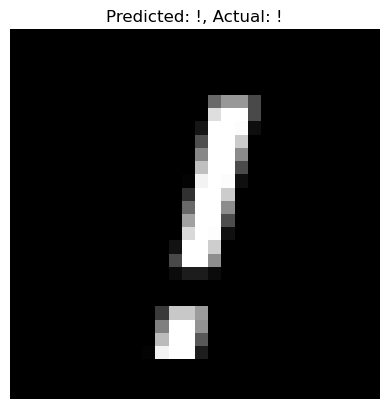


🧪 Testing sample #6
Prediction: _ (class 62)
Label     : _ (class 62)


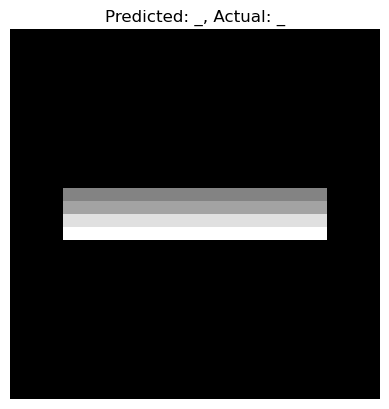


🧪 Testing sample #7
Prediction: m (class 76)
Label     : m (class 76)


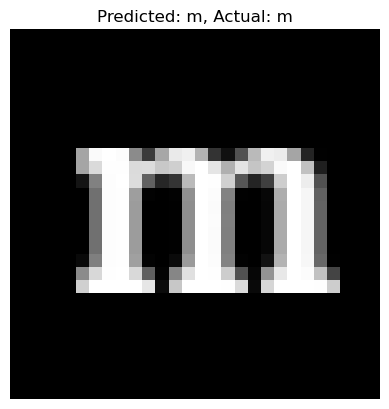


🧪 Testing sample #8
Prediction: K (class 42)
Label     : K (class 42)


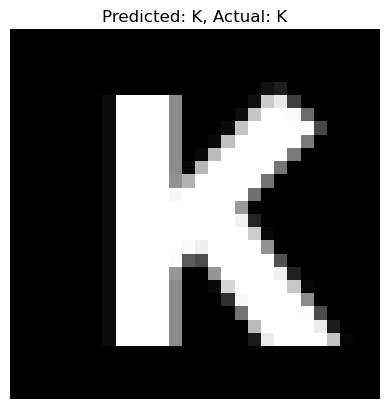


🧪 Testing sample #9
Prediction: u (class 84)
Label     : u (class 84)


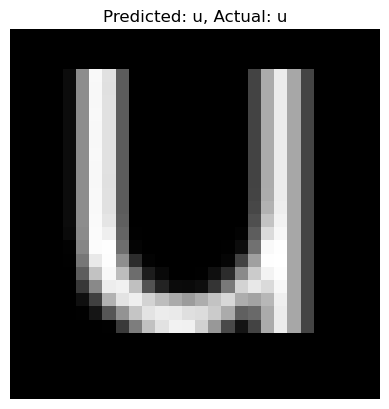


🧪 Testing sample #10
Prediction: / (class 14)
Label     : H (class 39)


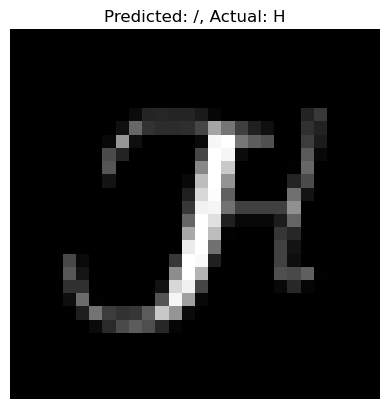


🧪 Testing sample #11
Prediction: y (class 88)
Label     : y (class 88)


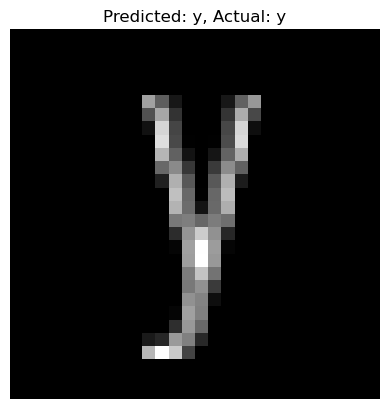


🧪 Testing sample #12
Prediction: A (class 32)
Label     : A (class 32)


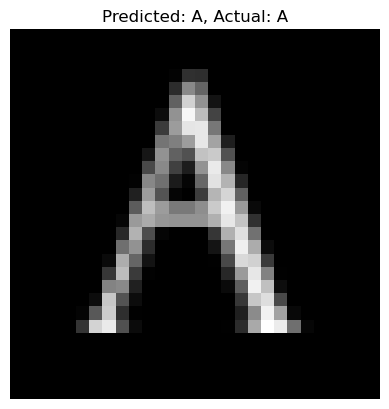


🧪 Testing sample #13
Prediction: c (class 66)
Label     : c (class 66)


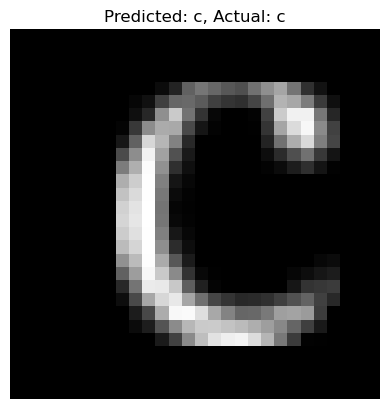


🧪 Testing sample #14
Prediction: = (class 28)
Label     : = (class 28)


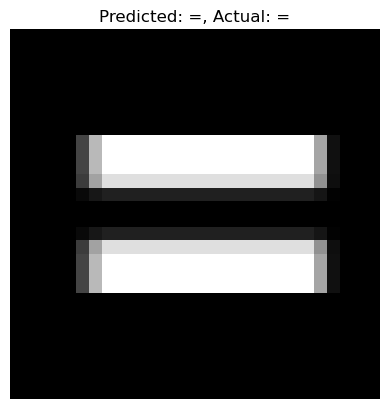


🧪 Testing sample #15
Prediction: 5 (class 20)
Label     : 5 (class 20)


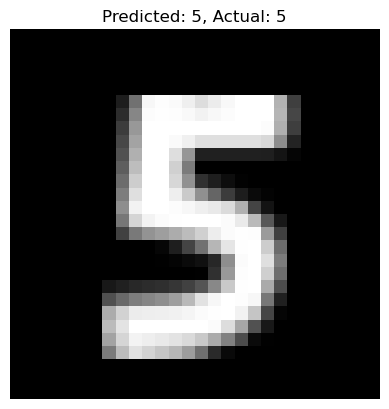


🧪 Testing sample #16
Prediction: f (class 69)
Label     : f (class 69)


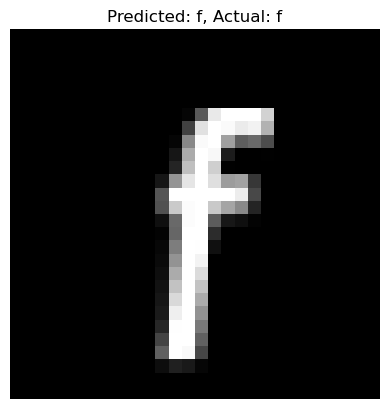


🧪 Testing sample #17
Prediction: ^ (class 61)
Label     : ^ (class 61)


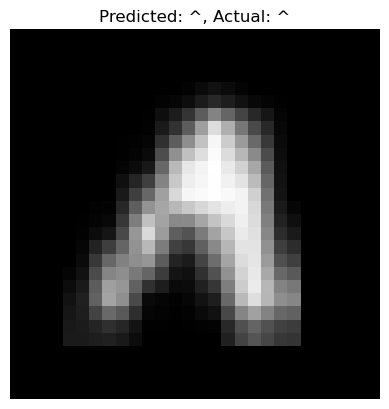


🧪 Testing sample #18
Prediction: 3 (class 18)
Label     : 3 (class 18)


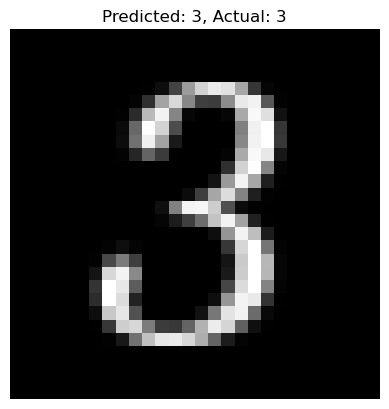


🧪 Testing sample #19
Prediction: / (class 14)
Label     : / (class 14)


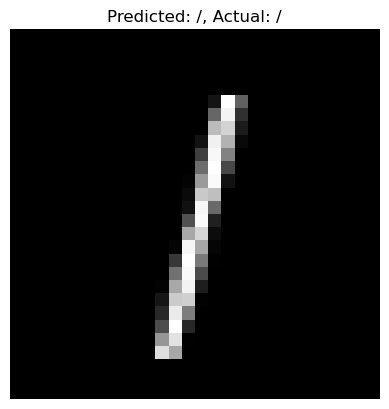

In [12]:
for i in range(20):
    print(f"\n🧪 Testing sample #{i}")
    test_prediction(i, W1, b1, W2, b2, W3, b3)



In [12]:
dev_predictions = make_predictions(X_dev,W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, Y_dev)


0.852

In [13]:
test_data = pd.read_csv("tmnist.csv").values

In [14]:
Y_test = data[:, 0]
X_test = data[:, 1:] / 255.
X_test = X_test.T

In [15]:
predictions = make_predictions(X_test,W1, b1, W2, b2, W3, b3)

In [16]:
accuracy = np.sum(predictions == Y_test) / Y_test.size

In [17]:
print(accuracy)

0.8405833056663249
